# Information Retrieval and Web Analytics

# Evaluation with Rank-Based Metrics


Welcome to the second practical lab!

In this session you are going to implement some common metrics used for the evaluation of an information retrieval system.


### Unranked retrieval evaluation: Precision and Recall

Having a given collection of documents:

**Precision:** is the fraction of the retrieved documents (A: answer set) which is relevant to the searched query.

$$\begin{equation}
  Precision=\frac{{|R \cap A|}}{{|A|}}
\end{equation}
$$



**Recall:** is the fraction of the relevant documents (R: relevant documents set) which has been retrieved.

$$\begin{equation}
  Recall=\frac{{|R \cap A|}}{{|R|}}
\end{equation}
$$

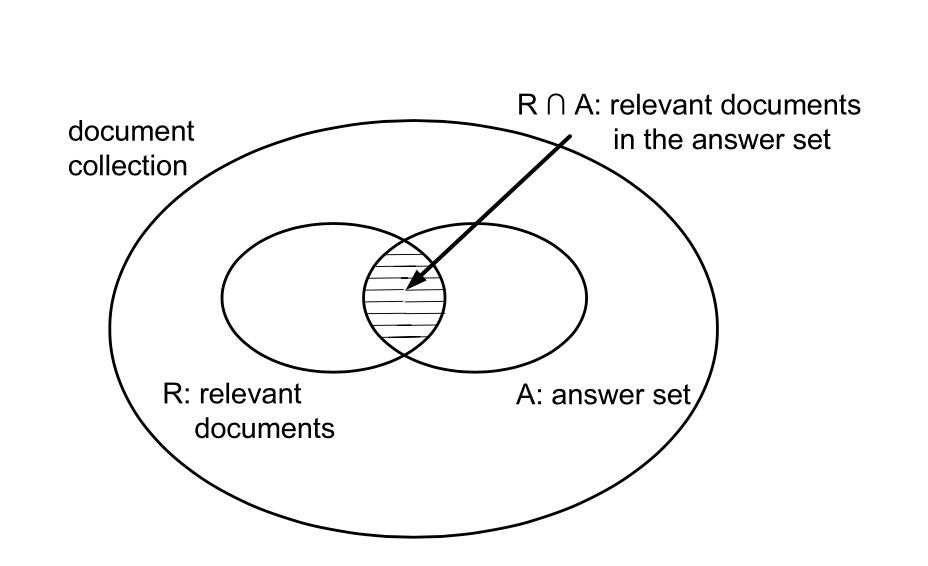
<center><caption> <u>Figure 1</u>: Precision and Recall</caption></center>


The above definitions of Precision and Recall assumes that all documents in the set A have been examined.

However, the user is not usually presented with all documents in the answer set A at once. User sees a **ranked set of documents** and examines them starting from the top. Thus, Precision and Recall vary as the user proceeds with their examination of the set A.


If we want to benchmark different systems about how well are they ranking the result documents, we need:

- A collection of **documents** that have to be representative of what we expect to find in reality;
- A collection of **information needs** that has to be representative of what a user might have in reality;
- Human relevance assessment for the (information need, document) pairs.

Information retrieval systems (like search engines) can express the relevance for a (information need, document) pair in a **binary** way or through **multiple levels**.

Here follow some common metrics used for the evaluation of a retrieval system:

### Rank-Based Measures
- ##### Binary relevance
    - Precision at K (P@K)
    - Average Precision at K (P@K)
    - Mean Average Precision (MAP)
    - Mean Reciprocal Rank (MRR)

K is the number of recommendations or ranked documents
    
- ##### Multiple levels of relevance
    - Normalized Discounted Cumulative Gain (NDCG)

Notice that we only mentioned Precision but not Recall. Indeed, by returning all the documents for a query will result in a trivial 100% recall, Thus recall by itself is commonly not used as a metric in this context.
    

### Prepare Data
We are going to test the above metrics on a ranking of results which is stored in the ```inputs/test_predictions.csv``` file. The prediction dataset contains:

- **query_id**: query id.
- **doc_id**: document id.
- **predicted_relevance**: relevance predicted through a ranking algorithm.
- **doc_score**: actual score of the document for the query (ground truth).

### 1 - Packages

In [ ]:
# you may install any missing package with: "python3 -m pip install <package_name>"

import numpy as np
import pandas as pd

### 2 - Load data into memory

In [ ]:
search_results = pd.read_csv("./data/test_predictions.csv")
search_results.head()

Notice that our ground truth consists of multiple levels:

In [ ]:
print_result = search_results["doc_score"].unique()
print("The ground truth of our dataset is composed of {} Relevance Levels: {}".format(len(print_result), sorted(print_result)))

### Binary Relevance

To compute *Precision@K, Mean Average Precision* and *Mean Reciprocal Rank*, we need binary relevance (1 = relevant, 0 = not relevant).


To simplify the task, we will consider as relevant **all documents that have actual score (y_true) equal or higher than $2$**, and not-relevant **the remaining documents**.

Let's add a column `is_relevant` to our previous table `search_results` following the above rule about **relevance**.

In [ ]:
search_results["is_relevant"] = search_results['doc_score'] >= 2
search_results.head()

### 3 - Metrics

#### Precision @ K (P@K)

Precision at K **(P@K) measures the number of relevant results among the top K documents**. It assesses whether the users are getting relevant documents at the top of the ranking or not.

A drawback of this metric is that it fails to take into account the positions of the relevant documents among the top K.

Python implementation:
Implement the function ```precision_at_k(y_true, y_score, k)``` that takes as input the true relevance labels, the predicted score, the number of documents to consider K and compute the precision as $k$.

Steps:
1. use ```np.argsort``` and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
2. use the indexes of point 1 to sort the actual relevance label of the documents (hint: ```np.take```).
3. consider the top K relevance label of the documents (after the sorting) and retrieve the number of relevant documents (among the top K, i.e., normalise the number of relevant documents by K).

Notice that the P@K is computed for a single query and the respective set of retrieved documents.

In [ ]:
def precision_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    '''
    order = np.argsort(y_score)[::-1]
    y_true = y_true[order[:k]]
    # y_true = np.take(np.array(y_true), order[:k])
    relevant = np.sum(y_true)
    return relevant / k

Compute Precision@10 for query with q_id=0:

In [ ]:
# Check for query 0

current_query = 0
current_query_res = search_results[search_results["query_id"] == current_query]

k = 5
print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))


print("\nCheck on the dataset sorted by score:\n")
#current_query_res.sort_values("score", ascending=False).head(k)
current_query_res.sort_values("predicted_relevance", ascending=False).head(k)

In [ ]:
k = 3
print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))


k=10
print("==> Precision@{}: {}\n".format(k,
                                precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)))



#### Average Precision@K - AP@K

With respect to $P@K$, $AP@K$ gives a better intuition of the model ability to sort the results for a specific query. It tells how much the relevant documents are concentrated in the highest ranked predictions.

The Average Precision approximates the area under the un-interpolated precision-recall curve.

$$AP@K=\frac{1}{GTP}\sum_k^n{P@K \times rel@K}\tag{1}$$

where:
- GTP is the total number of ground truth positives, within the retrieved K;
- P@K is the Precision at K ranked results.
- rel@K is a relevance function; it retrieves 1 if the document at rank K is relevant or 0 otherwise.

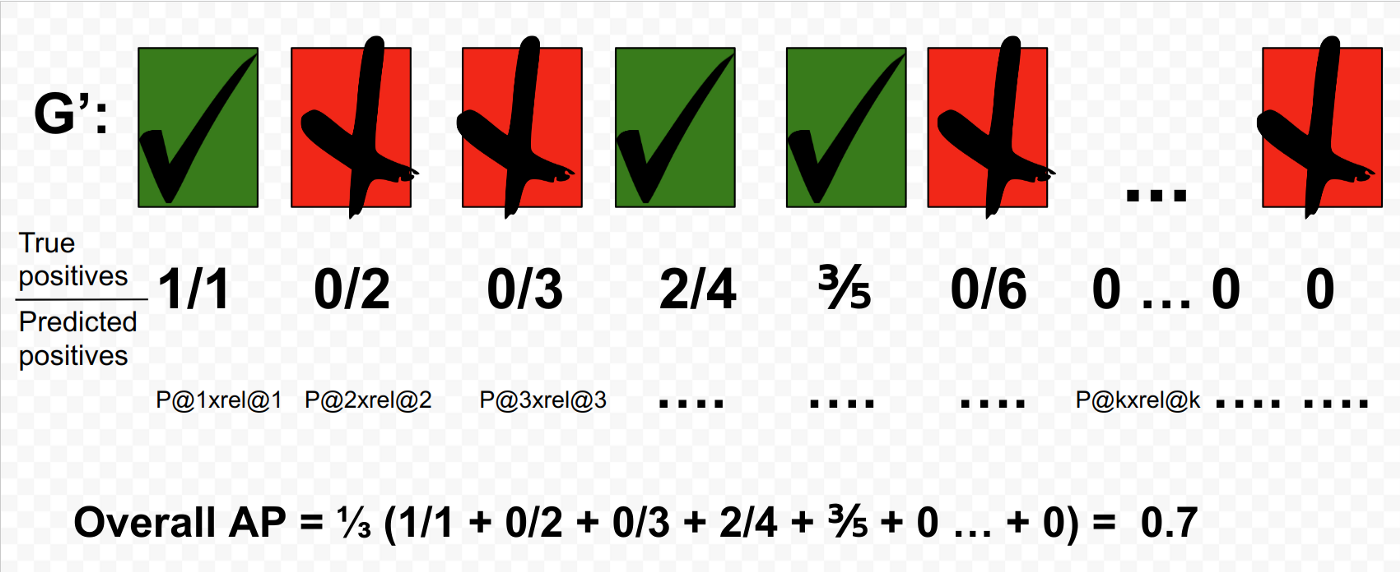

Python implementation:
Implement the function ```avg_precision_at_k(y_true, y_score, k)``` that computes the average precision at K. The function takes as inputs the true relevance labels, the predicted score, and the number of documents to consider K.

Notice that the Precision@K is computed for a single query and the respective set of retrieved documents.

In [ ]:
def avg_precision_at_k(y_true, y_score, k=10):
    """
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.

    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))

    for i in range(number_to_iterate):
        if y_true[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)

    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

Compute Precision@10 for the query with q_id=0:

In [ ]:
avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), 150)
#avg_precision_at_k(np.array([1,0,0,1,1,0]), np.array([0.9,0.8,0.7,0.6,0.5, 0.4]),6)

In [ ]:
# Check with 'average_precision_score' of 'sklearn' library

from sklearn.metrics import average_precision_score
k = 150
temp = current_query_res.sort_values("predicted_relevance", ascending=False).head(k)
average_precision_score(np.array(temp["is_relevant"]), np.array(temp["predicted_relevance"][:k]))

In [ ]:
# Check with 'average_precision_score' of 'sklearn' library

y_true = np.array([1, 1, 0, 1, 0, 0, 1])
y_scores = np.array([7, 6, 5, 4, 3, 2, 1])
assert (average_precision_score(y_true[:3], y_scores[:3]) == avg_precision_at_k(y_true, y_scores, 3))

Manual check:

In [ ]:
avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), 10)

In [ ]:
current_query_res.sort_values("predicted_relevance", ascending=False).head(10)

In [ ]:
(1 + (2 / 2) + (3 / 5) + (4 / 7) + (5 / 8) + (6 / 9)) / np.sum(current_query_res.sort_values("predicted_relevance", ascending=False)["is_relevant"].head(10))

#### Mean Average Precision (mAP)

The Mean Average Precision (mAP) is simply the **mean** of all the queries AP. This metric is not computed for a single query as previous metrics, but it takes into account all the queries.

Above we mentioned that the average precision approximates the area under the un-interpolated precision-recall curve for a single query. As a consequence, the mAP is roughly the average area under the precision-recall curve for a set of queries.

$$mAP=\frac{1}{N}\sum_{i=1}^n{AP_i}\tag{2}$$

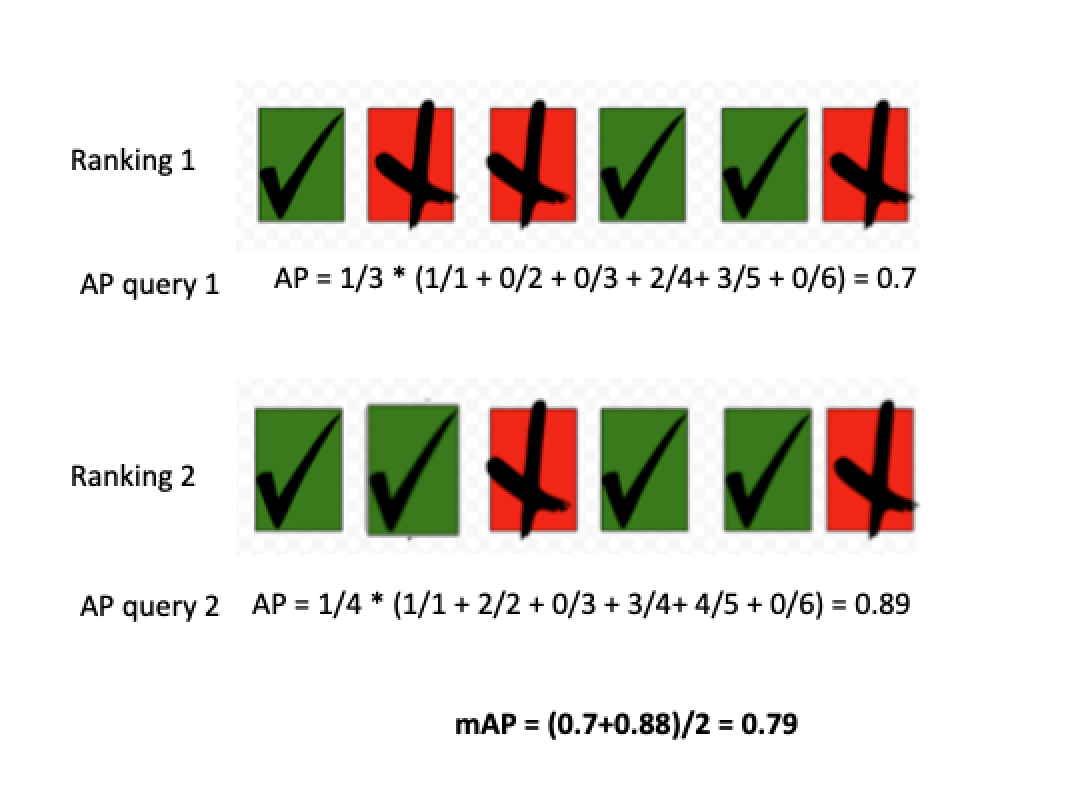

Implement a function ```map_at_k(search_res, k)``` that takes as input the dataset containing search results (list of actual labels, list of predicted scores, list queries) and k, and compute the Mean Average Precision (mAP).

In [ ]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["query_id"].unique():  #loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["is_relevant"]), np.array(curr_data["predicted_relevance"]),
                                      k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

Compute mAP@10 for all queries of the dataset:

In [ ]:
map_k, avp = map_at_k(search_results, 10)
map_k

#### Mean Reciprocal Rank (MRR)

Mean Reciprocal Rank is particularly used when we are interested in 'the first' correct answer.

If we define:

- $R_i$ as the ranking for the query $q_i$;
- $S_{correct}(R_i)$ as the position of the first correct answer in $R_i$
- $K$ as the threshold for ranking position

The reciprocal rank $$RR(R_i)$$ for query $q_i$ is computed as follows:

$$\begin{equation}
RR(R_i) =
\begin{cases}
\frac{1}{S_{correct}(R_i)}, & \text{if } S_{correct}(R_i) \le K \\
0, & \text{otherwise}
\end{cases}
\tag{3}
\end{equation}
$$


The Mean Reciprocal Rank (MRR) can be defined as the mean of the RR for all queries:

$$\begin{equation}
  MRR(R_i)==\frac{1}{N}\sum_{i=1}^N{RR(R_i)}
\end{equation}
\tag{4}
$$

where $N$ is the total number of queries (and rankings since we have a ranking per query).

Implement the function ```rr_at_k(y_true, y_score, k)``` that computes the Reciprocal Rank at the threshold $k$ for a single query and then compute the MRR@K for k=3, 5 and 10.

In [ ]:
def rr_at_k(y_true, y_score, k=10):
    """
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for current query
    """

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = y_true[order[:k]] # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(y_true)+1) # hint: to get the position of the first relevant document use "np.argmax"

In [ ]:
y_true = np.array([0, 1, 0, 1, 1])
score = np.array([0.9, 0.5, 0.6, 0.7, 0.2])
rr_at_k(y_true, score, 5)

##### Make some test with the query with q_id = 8 to check if your function is working properly.


In [ ]:
current_query = 8
current_query_res = search_results[search_results["query_id"] == current_query]
current_query_res.sort_values("predicted_relevance", ascending=False).head(10)

In [ ]:
labels = np.array(search_results[search_results['query_id'] == 8]["is_relevant"])
scores = np.array(search_results[search_results['query_id'] == 8]["predicted_relevance"])
np.round(rr_at_k(labels, scores, 10),4)

##### Compute the MRR@K for k=3,5,and 10.

In [ ]:
mrr = {}
for k in [3, 5, 10]:
    RRs = []
    for q in search_results['query_id'].unique():  # loop over all query ids
        labels = np.array(search_results[search_results['query_id'] == q]["is_relevant"])  # get labels for current query
        scores = np.array(search_results[search_results['query_id'] == q]["predicted_relevance"])  # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
    mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

In [ ]:
mrr

### Multiple levels of relevance metrics

#### NDCG - Normalized Discounted Cumulative Gain

**NDCG** also works if documents relevance are a real number, i.e., when each document's relevance is not expressed in a binary form (relevant or non-relevant).

This metric is especially used with machine learning based approaches, like 'Learning To Rank', and it takes values between $0$ (very poor/bad ranking) and $1$ (optimal ranking).

Before defining $NDCG$, let's talk about **Discounted Cumulative Gain (DCG)**:
**DCG** is based on the following assumptions:

- Highly relevant documents are more useful when appearing earlier in a search engine result list (have higher ranks)
- Highly relevant documents are more useful than marginally relevant documents, which are in turn more useful than non-relevant documents.

$DCG$ is based on the notion of **Cumulative Gain (CG)**:
**CG** does not include the position of a result in the consideration of the usefulness of a result set. It is the sum of the relevance values of all results in a search result list (in the ranking). Suppose you were presented with a set of search results for a query and asked to rank each result:
- 0 => Not relevant
- 1 => Near relevant
- 2 => Relevant

If we sum the values for a page of results we will have a measure of the cumulative gain (CG).

$$CG = \sum_{pos=1}^n Rel_{pos}\tag{5}$$

Where $Rel_{pos}$ is the graded relevance of $pos^{th}$ document.

Cumulative gain, however, does not reward relevant results that appear higher in the result set (CG function is unaffected by changes in the ordering of search results). To achieve the Discounted Cumulative Gain (DCG) we must discount results that appear lower.

**Discounted Cumulative Gain (DCG):** The premise of DCG is that highly relevant documents appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically proportional to the position of the result.

$$DCG = \sum_{pos=1}^n \frac{Rel_{pos}}{\log_2(pos+1)} = Rel_1 + \sum_{pos=2}^n \frac{Rel_{pos}}{\log_2(pos+1)}\tag{6}$$

An alternative formulation of $DCG$ that places stronger emphasis on retrieving relevant documents is the following:

$$DCG = \sum_{pos=1}^n \frac{2^{Rel_{pos}} -1}{\log_2(pos+1)}\tag{7}$$

The latter formula is commonly used in industry including major web search companies. These two formulations of DCG are the same when the relevance values of documents are binary.

**Normalized DCG (NDCG):** If you calculate DCG for different queries you’ll find that some queries are just harder than others and will produce lower DCG scores than easier queries. Normalization solves this problem by scaling the results based off of the best result seen. This is done by sorting all relevant documents in the corpus by their relative relevance, producing the maximum possible DCG through position $n$, also called **Ideal DCG (IDCG)** through that position (*usually it is the ground truth*).

$$NDCG_{pos} = \frac{DCG_{pos}}{iDCG}\tag{8}$$

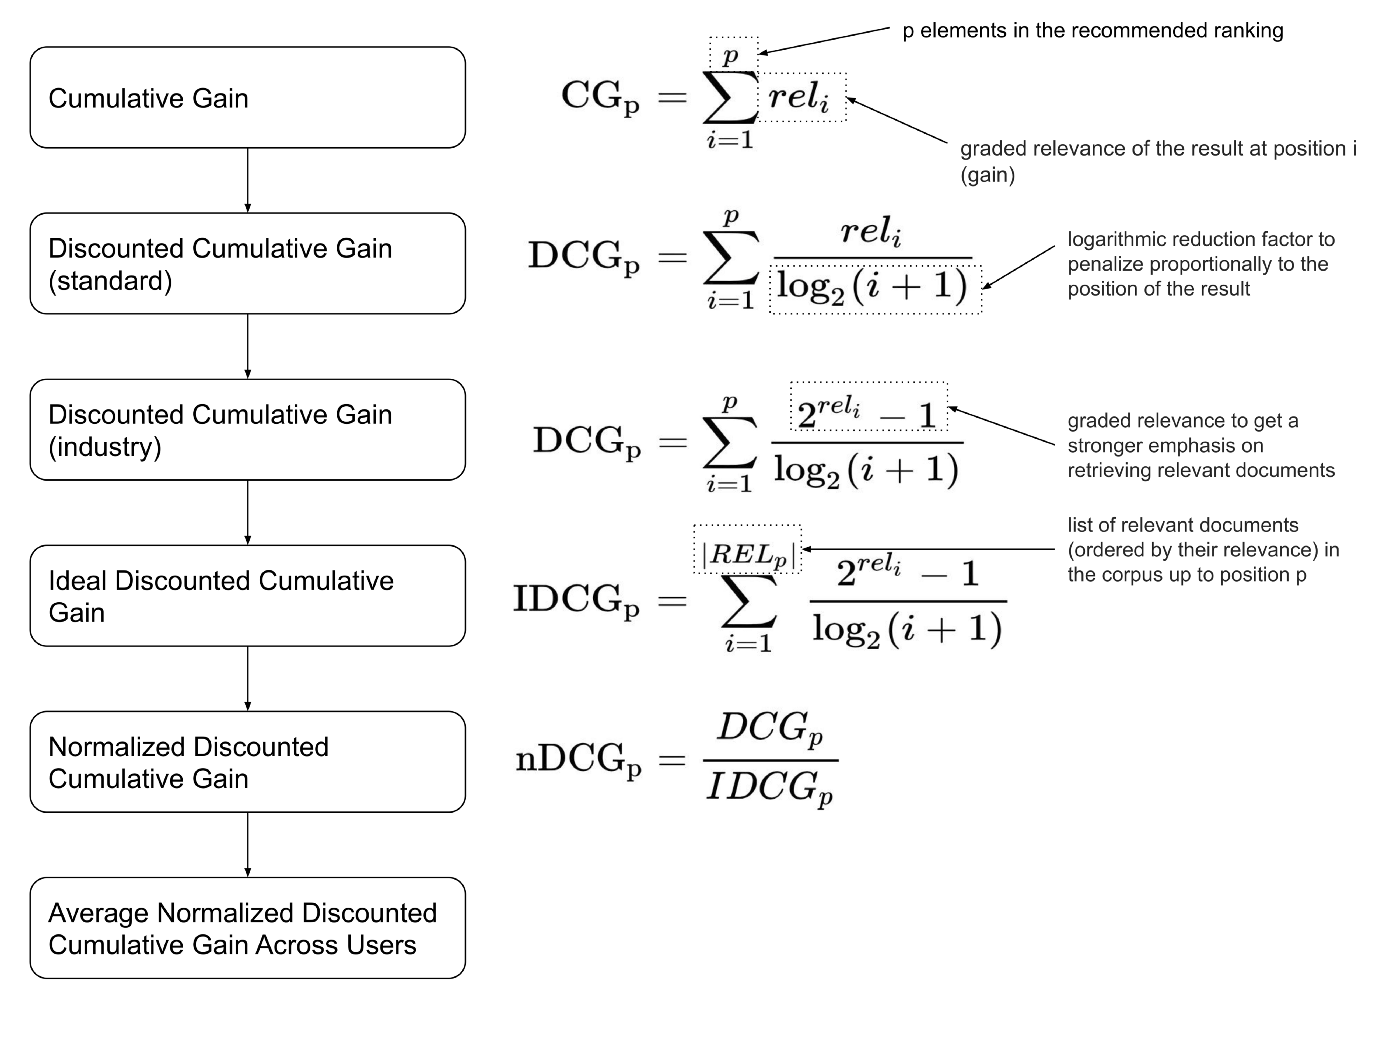

Implement the functions:
- ```dcg_at_k(y_score, y_true, k)``` based on formula $7$  
- ```ndcg_at_k(y_score, y_true, k)```

Compute:
- the $NDCG@10$ for query with ```q_id=0```
- the average $NDCG@10$ (considering all queries/rankings).

In [ ]:
def dcg_at_k(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** y_true - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):
    dcg_max = dcg_at_k(y_true, y_true, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k) / dcg_max, 4)

##### the  𝑁𝐷𝐶𝐺@10 for query with q_id=0

In [ ]:
q_id = 0
k = 10
labels = np.array(search_results[search_results['query_id'] == q_id]["doc_score"])
scores = np.array(search_results[search_results['query_id'] == q_id]["predicted_relevance"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k), 4)
print("ndcg@{} for query with query_id={}: {}".format(k, q_id, ndcg_k))

##### the average  𝑁𝐷𝐶𝐺@10  (considering all queries/rankings).

In [ ]:
ndcgs = []
k = 10
for q in search_results['query_id'].unique():
    labels = np.array(search_results[search_results['query_id'] == q]["doc_score"])
    scores = np.array(search_results[search_results['query_id'] == q]["predicted_relevance"])
    ndcgs.append(np.round(ndcg_at_k(labels, scores, k), 4))

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)), 4)
print("Average ndcg@{}: {}".format(k, avg_ndcg))